# Training

The P2PNet architecture produces, for each input image, a set of candidate head locations and associated confidence scores. Training the network therefore requires more than a simple pixel-wise loss. We need a way to decide which prediction should be responsible for which ground-truth head, and penalize both localization errors and classification errors in a consistent way. This is typically done using a matching algorithm, which assigns each ground-truth head to a predicted location based on some criteria. Once the assignments are made, we can evaluate the localization and classification errors over the matched pairs, and use these errors to compute the overall loss function for training.

## Point matching

For a given training image, suppose there are $N$ annotated heads (targets), represented as points

$$
p_i = (x_i, y_i), \quad i = 1, \ldots, N.
$$

After passing the image through P2PNet, we obtain:
- a tensor of predicted offsets of shape $(2, A, H_f, W_f)$, where $A$ is the number of anchors per grid cell, and $H_f, W_f$ are are the spatial dimensions of the prediction grid;
- a tensor of logits (classification scores before sigmoid) of shape $(A, H_f, W_f)$.

Decoding the offsets yields a set of $M = A \times H_f \times W_f$ predicted points

$$
\hat{p}_j = (\hat{x}_j, \hat{y}_j), \quad j = 1, \ldots, M,
$$

together with their associated confidence scores $\hat{c}_j$.

Both the targets and the predictions are unordered sets of points. The network does not predict an explicit ordering, and the number of predictions is typically larger than the number of heads ($M > N$). This makes training fundamentally different from standard regression: we cannot simply line up predictions and targets by index and apply a mean squared error. Instead, we must first decide which prediction should be matched to which ground-truth point.

### Linear assignment

P2PNet uses a one-to-one assignment between predicted points and ground-truth points. Each ground-truth point is matched to at most one prediction, and each prediction is matched to at most one ground truth. This is known as a **linear assignment problem**. To solve this problem optimally, we need to define a matrix where each entry represents the cost of matching a prediction $\hat{p}_j$ with a target $p_i$. 

The simplest choice to build such a cost matrix would be to consider only the Euclidean distance between each pair of predicted and target points. However, we also care about the confidence score: a good positive match should not only be close to the ground truth, but also have a high predicted confidence. P2PNet combines both aspects in a single matching cost of the form

$$
{\rm cost}_{ij} = \tau \, \| p_i - \hat{p}_j \|_2 - {\rm sigmoid}(\hat{c}_j),
$$

where $\tau > 0$ is a hyperparameter that balances the influence of distance and score. A lower cost is better, meaning that points closer to the ground truth and with higher scores are preferred.

:::{note}
Make sure to use the sigmoid of the logits when computing the cost, not the raw logits.
:::

### Implementation

The assignment problem can be solved with the `scipy.optimize.linear_sum_assignment` function. The code snippet below illustrates how to use this function, given the cost matrix computed as above. In practice, it is common to ensure that $M \ge N$, so that each target can be matched to some prediction.

In [1]:
import torch
from scipy.optimize import linear_sum_assignment


def hungarian_matching(cost: torch.Tensor):
    """
    Given a cost matrix, compute the optimal one-to-one matching.

    Parameters
    ----------
    cost: torch.Tensor
        A 2D tensor where each element represents the cost of assigning each target to each prediction.
    
    Returns
    -------
    row_ind: torch.Tensor
        Indices of the matched points representing the rows of the cost matrix.
    col_ind: torch.Tensor
        Indices of the matched points representing the columns of the cost matrix.
    """

    # Compute the optimal assignment
    cost_np = cost.cpu().detach().numpy()
    row_ind, col_ind = linear_sum_assignment(cost_np)

    # Convert the matched indices to torch tensors
    row_ind = torch.tensor(row_ind, dtype=torch.int64, device=cost.device)
    col_ind = torch.tensor(col_ind, dtype=torch.int64, device=cost.device)

    return row_ind, col_ind

The figure below illustrates the matching process. The red circles are the targets, while the blue crosses are the matched predictions. Dashed lines connect each target to its assigned prediction.

In [2]:
import matplotlib.pyplot as plt
from solution.P2PNet.dataset import ShanghaiTechDataset

def make_anchors(height, width, stride=8, device="cpu"):
    Hf = height // stride
    Wf = width  // stride

    # Centers of each 8x8 patch
    ys = (torch.arange(Hf, device=device) + 0.5) * stride  # row centers
    xs = (torch.arange(Wf, device=device) + 0.5) * stride  # column centers
    grid_y, grid_x = torch.meshgrid(ys, xs, indexing="ij") # shape (Hf, Wf)

    # Adjust to get N=4 anchors per grid cell
    grid_x = grid_x.unsqueeze(0).repeat(4, 1, 1)  # shape (N, Hf, Wf)
    grid_y = grid_y.unsqueeze(0).repeat(4, 1, 1)  # shape (N, Hf, Wf)
    
    delta = stride // 4
    grid_x[[0, 2]] -= delta
    grid_x[[1, 3]] += delta
    grid_y[[0, 1]] -= delta
    grid_y[[2, 3]] += delta
    
    anchors = torch.stack([grid_x, grid_y], dim=0)  # shape (2, N, Hf, Wf)
    return anchors

In [3]:
ds = ShanghaiTechDataset('solution/.data')
img, targets = ds[3]

targets = torch.tensor(targets, dtype=torch.float32) # shape (N, 2)
assert targets.ndim == 2 and targets.shape[1] == 2

W, H = img.size
anchors = make_anchors(H, W, stride=64)
anchors = anchors.reshape(2, -1).transpose(0, 1)  # shape (M, 2)
assert anchors.ndim == 2 and anchors.shape[1] == 2

cost = torch.cdist(targets, anchors) # shape (N, M)
true_idx, pred_idx = hungarian_matching(cost)

matched_targets = targets[true_idx]  # shape (N, 2)
matched_points = anchors[pred_idx]  # shape (N, 2)

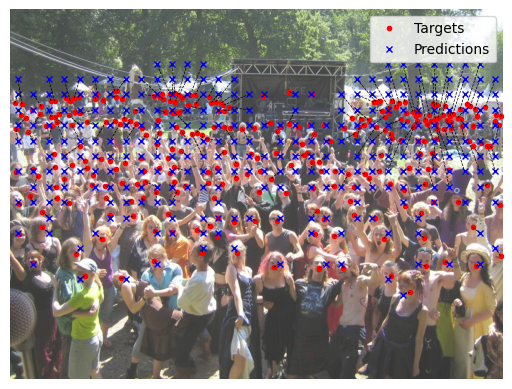

In [7]:
plt.imshow(img, alpha=0.8)
plt.plot(matched_targets[:, 0], matched_targets[:, 1], 'ro', markersize=3, label='Targets')
plt.plot(matched_points[:, 0], matched_points[:, 1], 'bx', markersize=4, label='Predictions')
for t, p in zip(matched_targets, matched_points):
    plt.plot([t[0], p[0]], [t[1], p[1]], 'k--', linewidth=0.5)
plt.legend()
plt.axis('off')
plt.show()

## Loss function

The loss function for one image is computed as the sum of the localization error over the matched pairs and the classification error over all predictions. Mathematically, this can be expressed as

$$
\mathcal{L} = L_{\rm cls} + \lambda \, L_{\rm loc}
$$

where $\lambda$ is a small coefficient that controls the relative importance of localization compared to classification. This coefficient is chosen so that both terms have comparable numerical scale during training.

### Localization loss

The localization loss encourages the network to adjust the offsets of matched predictions such that they align closely with the ground-truth head locations. This is done by penalizing the mean squared distance between each ground-truth point $p_i$ and its matched prediction $\hat{p}_{\xi(i)}$, where $\xi(i)$ is the index of the prediction assigned to target $i$.

$$
L_{\rm loc} = \frac{1}{K} \sum_{i=1}^{K} \| p_i - \hat{p}_{\xi(i)} \|_2^2
$$

Here, $K$ is the number of matched pairs, which is typically the number of ground-truth heads ($K=N$). The following code snippet shows how to compute the localization loss in PyTorch.

```python
cost = compute_cost_matrix(targets, preds, logits, tau)  # shape (N, M)

true_idx, pred_idx = hungarian_matching(cost)

matched_targets = targets[true_idx]  # shape (N, 2)
matched_preds   = preds[pred_idx]    # shape (N, 2)

loc_loss = torch.nn.functional.mse_loss(matched_preds, matched_targets)
```

:::{note}
This loss only penalizes matched predictions. Unmatched proposals are not used.
:::

### Classification loss

The classification loss encourages the network to assign high confidence scores to matched predictions, and low scores to unmatched predictions. This is implemented as a binary classification problem, where each prediction is classified as either positive or negative based on whether it has been assigned to a ground-truth point in the matching process. Let $\hat{c}_j$ be the raw logit output for prediction $j$, and let $y_j \in \{0, 1\}$ be its label. That is, $y_j = 1$ if the index $j$ is in the set of matched prediction indices, and $y_j = 0$ otherwise. The binary cross-entropy with logits averaged over all predictions reads as follows.

$$
L_{\rm cls} = - \frac{1}{M} \sum_{j=1}^{M} \left[ y_j \log({\rm sigmoid}(\hat{c}_j)) + \lambda_{\rm neg} (1 - y_j) \log(1 - {\rm sigmoid}(\hat{c}_j)) \right]
$$

Here, $\lambda_{\rm neg}$ is a hyperparameter that controls the contribution of negative samples in the loss. This is useful to address class imbalance, since most predictions are expected to be negatives (i.e., not matched to any ground-truth point). The following code snippet shows how to compute the classification loss in PyTorch.

```python
labels = torch.zeros_like(logits)
labels[pred_idx] = 1.0   # set positive labels for matched predictions

weights = torch.full_like(logits, lambda_neg)
weights[pred_idx] = 1.0

cls_loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, labels, weight=weights)
```

:::{note}
This loss takes into account all predictions, both matched and unmatched.
:::

## Summary

Putting all pieces together, a single training iteration for one batch proceeds as follows:

1. **Forward pass.** Feed a batch of images through P2PNet to obtain offsets and logits. Decode the offsets into predicted coordinates in image space.

2. **Point matching.** For each image in the batch, build the cost matrix between its predicted points and ground-truth points; run the Hungarian algorithm to obtain the one-to-one matching; collect the matched and unmatched prediction indices.

3. **Loss function.**  For each image, compute the localization loss on matched pairs and the classification loss on all predictions, using the labels derived from the matching. Average losses over the batch.

4. **Backward pass.** Combine the two losses with the chosen weighting, backpropagate, and update the network parameters using your optimizer of choice.

With this training objective, P2PNet learns to produce a set of point proposals such that, after optimal matching, each ground-truth head is explained by exactly one confident, well-localized prediction, and spurious proposals are assigned low confidence and treated as background.

:::{tip}
Follow a training strategy similar to fine-tuning to improve stability.
- Start from a P2PNet model initialized with pretrained VGG-16 weights, and initially freeze the backbone so that only the neck and prediction heads are updated. Train this configuration until the loss stabilizes and the model begins to produce reasonable matches. 
- Then unfreeze the backbone and continue training the entire network end-to-end, typically with a smaller learning rate.
:::